In [1]:
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics
from sklearn import manifold
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# import dataset
data = pd.read_csv('2021-11-ml-09-k-means-animals-dataset.csv')

In [3]:
# view dataset
data.head(5)
# change comments column to int and drop nulls
data.drop(['Region', 'Stage', 'Individual ID', 'Comments'], axis=1, inplace=True)
# drop nulls
data.dropna(axis=0, thresh=4, inplace=True)
# review dataset
data.head(5)

,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Delta 15 N (o/oo),Delta 13 C (o/oo)
0,39.1,18.7,181.0,3750.0,NaN,NaN
1,39.5,17.4,186.0,3800.0,8.94956,-24.69454
2,40.3,18.0,195.0,3250.0,8.36821,-25.33302
4,36.7,19.3,193.0,3450.0,8.76651,-25.32426
5,39.3,20.6,190.0,3650.0,8.66496,-25.29805


In [4]:
# standardize data, ETL
impute_mean = SimpleImputer(strategy='mean')
data_std = pd.DataFrame(impute_mean.fit_transform(data))

In [5]:
# copy over columns
data_std.columns = data.columns
# rename columns
data_std.rename(columns={'Culmen Length (mm)':'CulmenLength','Culmen Depth (mm)':'CulmenDepth','Flipper Length (mm)':'FlipperLength','Body Mass (g)':'BodyMass','Delta 15 N (o/oo)':'Delta15N','Delta 13 C (o/oo)':'Delta13C'}, inplace=True)  

In [6]:
#view standardized data frame
data_std.head()

,CulmenLength,CulmenDepth,FlipperLength,BodyMass,Delta15N,Delta13C
0,39.1,18.7,181.0,3750.0,8.733382,-25.686292
1,39.5,17.4,186.0,3800.0,8.949560,-24.694540
2,40.3,18.0,195.0,3250.0,8.368210,-25.333020
3,36.7,19.3,193.0,3450.0,8.766510,-25.324260
4,39.3,20.6,190.0,3650.0,8.664960,-25.298050


In [7]:
# investigate correlations in dataset
data_std.corr()

,CulmenLength,CulmenDepth,FlipperLength,BodyMass,Delta15N,Delta13C
CulmenLength,1.000000,-0.235053,0.656181,0.595110,-0.058562,0.185820
CulmenDepth,-0.235053,1.000000,-0.583851,-0.471916,0.596275,0.424059
FlipperLength,0.656181,-0.583851,1.000000,0.871202,-0.495253,-0.366999
BodyMass,0.595110,-0.471916,0.871202,1.000000,-0.530444,-0.369514
Delta15N,-0.058562,0.596275,-0.495253,-0.530444,1.000000,0.565634
Delta13C,0.185820,0.424059,-0.366999,-0.369514,0.565634,1.000000


In [8]:
#In order to find the best epsilon value, we created a K-Distance graph and located the point of maximum curvature on the Y-Axis.
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(data_std)
distances, indices = nbrs.kneighbors(data_std)

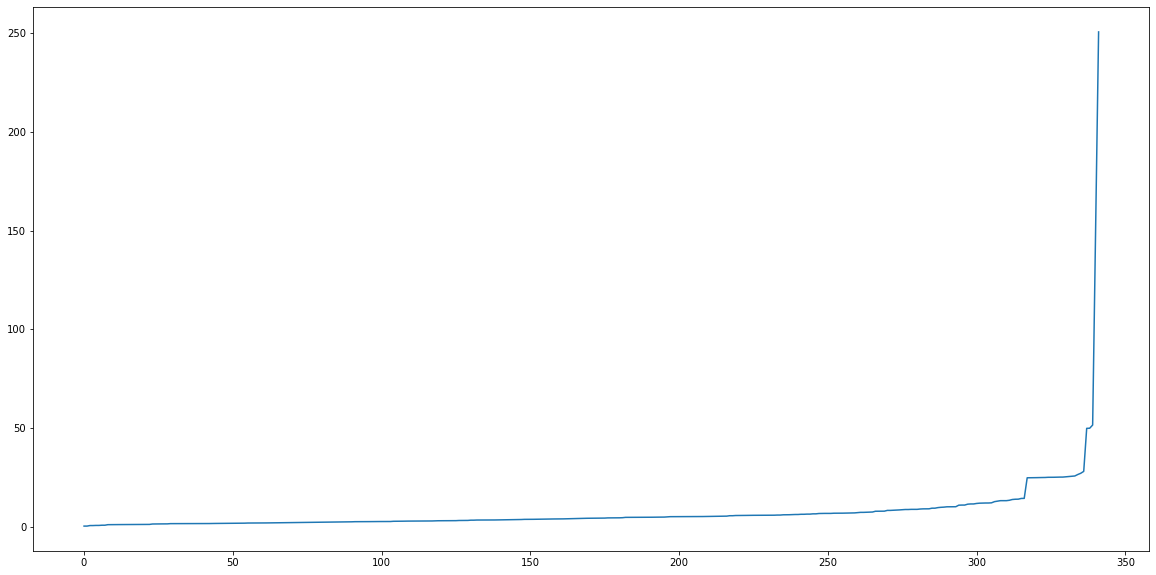

In [9]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(20,10))
#plt.xlabel()
#plt.ylabel()
plt.plot(distances)
plt.show()
#Based on the graph, a value of 1.0 is likely a reasonable value for epsiolon in the DBScan.

In [10]:
# # flipper length and body mass
# x = data_std['BodyMass']
# y = data_std['FlipperLength']
# create plot
# ax = sns.scatterplot(x=x, y=y)
# ax.set_xlabel('Body Mass (g)')
# ax.set_ylabel('Flipper Length (mm)')
# ax.set_title('Flipper Length vs. Body Mass')
# plt.show()

In [11]:
X = StandardScaler().fit_transform(data_std)

In [12]:
X

array([[-0.88449874,  0.78544923, -1.41834665, -0.56414208,  0.        ,
         0.        ],
       [-0.81112573,  0.1261879 , -1.06225022, -0.50170305,  0.39945592,
         1.27162683],
       [-0.66437972,  0.43046236, -0.42127665, -1.18853234, -0.67476705,
         0.45296584],
       ...,
       [ 1.18828874, -0.73592307,  1.50164406,  1.93341896, -0.79773864,
        -0.45502623],
       [ 0.23443963, -1.19233476,  0.7894512 ,  1.24658968, -0.90712885,
        -0.55570482],
       [ 1.09657248, -0.53307343,  0.86067049,  1.49634578, -0.6827311 ,
        -0.60137689]])

In [13]:
# Compute DBSCAN
db = DBSCAN(eps=1,min_samples=8)
db.fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

In [14]:
# Number of clusters in labels, ignoring noise if present.
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

In [15]:
print('Estimated number of clusters: %d' % n_clusters)
print('Estimated number of noise points: %d' % n_noise)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

Estimated number of clusters: 3
Estimated number of noise points: 37
Silhouette Coefficient: 0.369


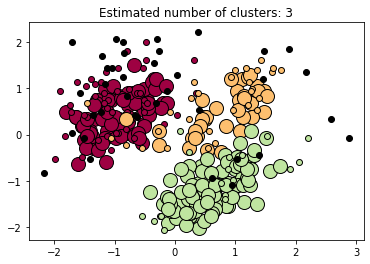

In [16]:
# Plot result
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters)
plt.show()

In [17]:
# create clusters
clustering = DBSCAN(eps=1, min_samples=12).fit(data_std)

labelsList = ['Noise']
labelsList = labelsList + ['Cluster ' + str(i) for i in range(1,len(set(clustering.labels_)))]

clusters = clustering.labels_

print(clusters)

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1

In [18]:
# # create dbscan plot
# dbs_df = data_std
# dbs_df['Cluster'] = clusters
# u_label = np.unique(clusters)

# for i in u_label:
#     temp_df = dbs_df[dbs_df['Cluster'] == i]
#     ax = sns.scatterplot(x=temp_df['BodyMass'], y=temp_df['FlipperLength'])
#     ax.set(title='Flipper Length vs. Body Mass, DBSCAN Clusters')
    

## Kmeans

In [19]:
# import dataset
df = pd.read_csv('2021-11-ml-09-k-means-animals-dataset.csv')

In [20]:
# view dataset
df.head(5)
# change comments column to int and drop nulls
df.drop(['Region', 'Stage', 'Individual ID', 'Comments'], axis=1, inplace=True)
# drop nulls
df.dropna(axis=0, thresh=4, inplace=True)
# review dataset
df.head(5)

,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Delta 15 N (o/oo),Delta 13 C (o/oo)
0,39.1,18.7,181.0,3750.0,NaN,NaN
1,39.5,17.4,186.0,3800.0,8.94956,-24.69454
2,40.3,18.0,195.0,3250.0,8.36821,-25.33302
4,36.7,19.3,193.0,3450.0,8.76651,-25.32426
5,39.3,20.6,190.0,3650.0,8.66496,-25.29805


In [21]:
# standardize data, ETL
impute_mean = SimpleImputer(strategy='mean')
z_data = pd.DataFrame(impute_mean.fit_transform(df))
# copy over columns
z_data.columns = df.columns
# rename columns
z_data.rename(columns={'Culmen Length (mm)':'CulmenLength','Culmen Depth (mm)':'CulmenDepth','Flipper Length (mm)':'FlipperLength','Body Mass (g)':'BodyMass','Delta 15 N (o/oo)':'Delta15N','Delta 13 C (o/oo)':'Delta13C'}, inplace=True)  
#view standardized data frame
z_data.head()

,CulmenLength,CulmenDepth,FlipperLength,BodyMass,Delta15N,Delta13C
0,39.1,18.7,181.0,3750.0,8.733382,-25.686292
1,39.5,17.4,186.0,3800.0,8.949560,-24.694540
2,40.3,18.0,195.0,3250.0,8.368210,-25.333020
3,36.7,19.3,193.0,3450.0,8.766510,-25.324260
4,39.3,20.6,190.0,3650.0,8.664960,-25.298050


In [22]:
X = z_data._get_numeric_data()

X.dropna(inplace=True)

ss = StandardScaler()

X = ss.fit_transform(X)

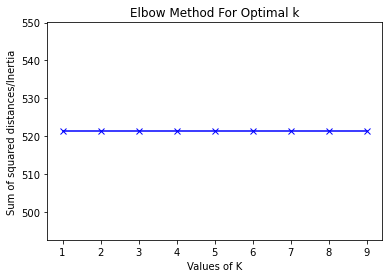

In [23]:
from sklearn.datasets import make_blobs

Sum_of_squared_distances = []
K = range(1,10)
for num_clusters in K:
    km = KMeans(n_clusters=5, random_state=0)
    km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

In [24]:
km = KMeans(n_clusters=3, random_state=0)
km.fit(X)

KMeans(n_clusters=3, random_state=0)

In [25]:
km.cluster_centers_

array([[-0.96890336,  0.57586157, -0.7938083 , -0.66347689,  0.16336447,
        -0.2099833 ],
       [ 0.65722922, -1.09998045,  1.15886506,  1.0917612 , -0.89447856,
        -0.63462537],
       [ 0.75939454,  0.69670251, -0.38191863, -0.51854516,  1.14025978,
         1.4221912 ]])

In [26]:
km.labels_

array([0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [27]:
data['cluster'] = km.labels_

centroids = data.groupby(by='cluster').mean()

data.head()

,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Delta 15 N (o/oo),Delta 13 C (o/oo),cluster
0,39.1,18.7,181.0,3750.0,NaN,NaN,0
1,39.5,17.4,186.0,3800.0,8.94956,-24.69454,0
2,40.3,18.0,195.0,3250.0,8.36821,-25.33302,0
4,36.7,19.3,193.0,3450.0,8.76651,-25.32426,0
5,39.3,20.6,190.0,3650.0,8.66496,-25.29805,0


In [28]:
centroids

,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Delta 15 N (o/oo),Delta 13 C (o/oo)
cluster,,,,,,
0,38.639860,18.286713,189.769231,3670.454545,8.828439,-25.862372
1,47.504878,14.982114,217.186992,5076.016260,8.245338,-26.185298
2,48.061842,18.525000,195.552632,3786.513158,9.358697,-24.577114


In [29]:
for i in data.columns[1:6]:
    print(i)

Culmen Depth (mm)
Flipper Length (mm)
Body Mass (g)
Delta 15 N (o/oo)
Delta 13 C (o/oo)


<Figure size 504x504 with 0 Axes>

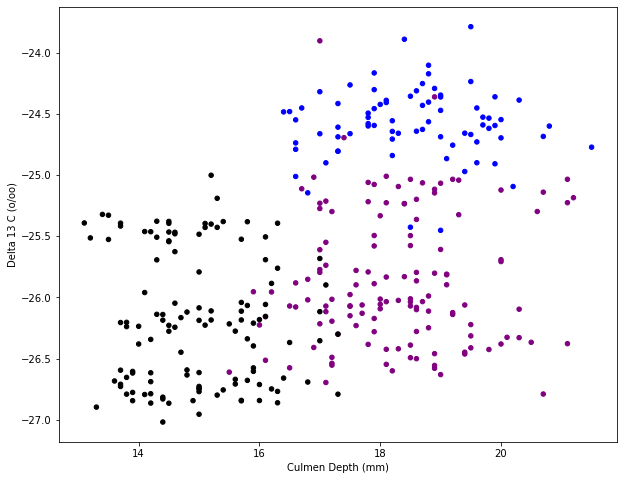

<Figure size 504x504 with 0 Axes>

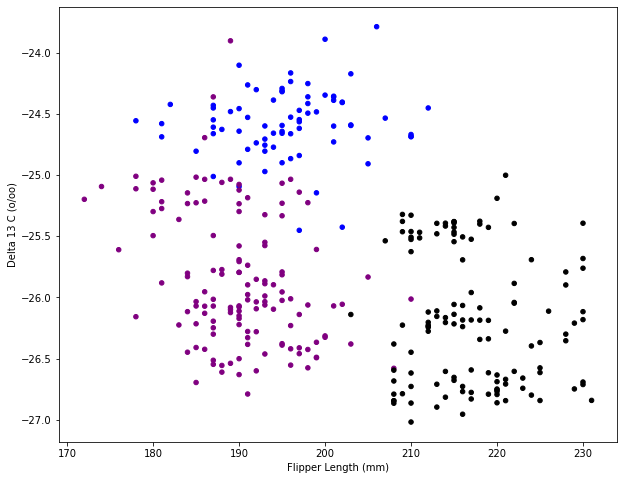

<Figure size 504x504 with 0 Axes>

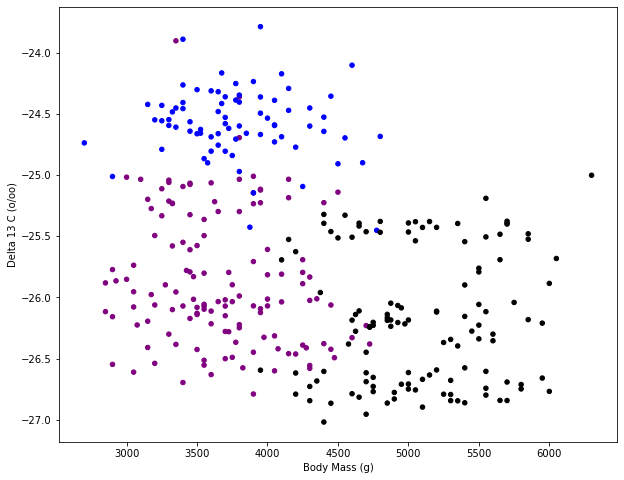

<Figure size 504x504 with 0 Axes>

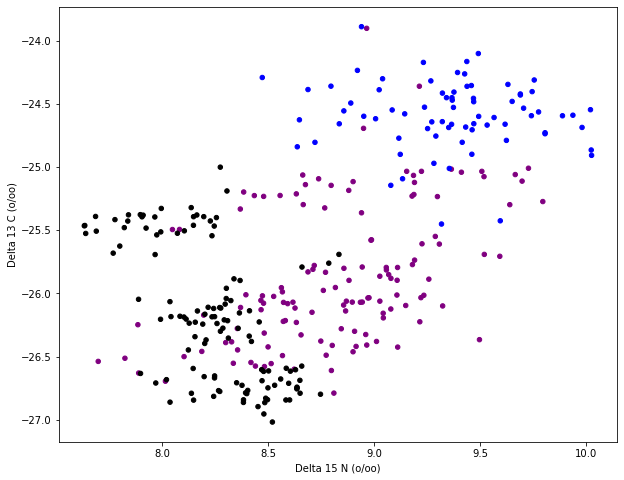

<Figure size 504x504 with 0 Axes>

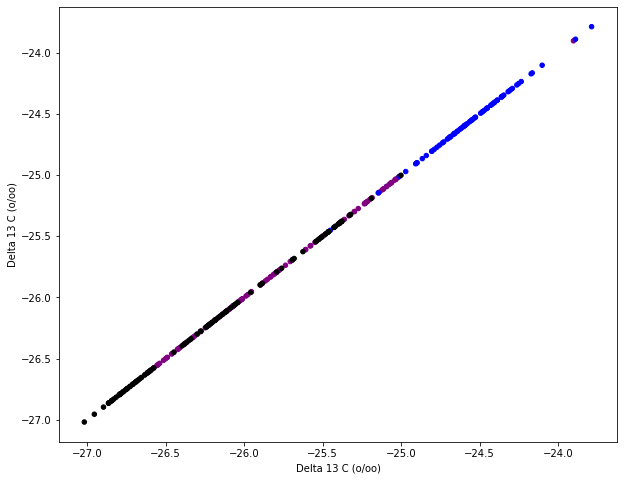

In [30]:
for i in data.columns[1:6]:


    plt.figure(figsize=(7,7));

    ## Plot scatter by cluster / color, and centroids
    colors = ["purple", "black", "blue", 'orange']
    data['color'] = data['cluster'].map(lambda p: colors[p]);

    ax = data.plot(    
        kind="scatter", 
        x=i, y="Delta 13 C (o/oo)",
        figsize=(10,8),
        c = data['color']
    );

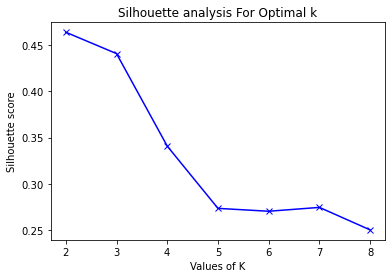

In [31]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
silhouette_avg = []
for num_clusters in range_n_clusters:
 
 # initialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    kmeans.fit(X)
    cluster_labels = kmeans.labels_
 
 # silhouette score
    silhouette_avg.append(silhouette_score(X, cluster_labels))
plt.plot(range_n_clusters, silhouette_avg,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

In [32]:
scores = []

for k in range(2, 20):
    
    #Clusters
    km = KMeans(n_clusters = k, random_state = 0)
    km.fit(X)
    
    # Get my silhouette scores
    sil = silhouette_score(X, km.labels_)
    
    #Append these scores to my scores list
    scores.append((k, sil))
    
scores_df = pd.DataFrame(scores, columns=['k', 'silhouette_score'])

scores_df

,k,silhouette_score
0,2,0.463759
1,3,0.440704
2,4,0.340854
3,5,0.273659
4,6,0.270561
5,7,0.274711
6,8,0.250409
7,9,0.251212
8,10,0.247288
9,11,0.218583
